# Taking a first look and cleaning the data.
* [Data Source](https://airtable.com/appeVUdmRBi3K9hTS/tblLywLvMA2OTesQP/viwRRKOaZvvkSNfmU?blocks=hide)
* [Term Explanations](https://docs.calitp.org/data-infra/datasets_and_tables/transitdatabase.html)
* Look at all the data gathered in Transit Stacks to see what products/vendors/etc are out there. It's not too efficient for agencies to use so many different vendors/products, how can Caltrans help create some consistency?

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 50
pd.options.display.max_rows = 250
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calitp import *
from PIL import Image
from siuba import *
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

## Products Data

In [2]:
# drop columns with tons of NAs
products = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}products-Grid view (1).csv"))
    .drop(
        columns=[
            "business_model_features",
            "attachments",
            "status",
            "certifications",
            "connectivity",
            "accepted_input_components",
            "output_components",
            "input",
            "output",
        ]
    )
    .rename(columns={"name": "product_name"})
)

In [3]:
products.columns

Index(['product_name', 'components', 'vendor', 'url', 'requirements',
       'product_features', 'notes', 'organization_stack_components'],
      dtype='object')

In [4]:
products.isna().sum()

product_name                       0
components                        10
vendor                            39
url                               70
requirements                     233
product_features                 180
notes                            174
organization_stack_components    103
dtype: int64

In [5]:
products = products.fillna("N/A")

In [6]:
### Count number of strings in organization_stack_components column to see how many orgs are using this vendor.
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
products["count_of_orgs_using_product"] = (
    products["organization_stack_components"]
    .str.split(",+")
    .str.len()
    .groupby(products.product_name)
    .transform("sum")
)

In [7]:
unique_vendors = products.vendor.nunique()
f"{unique_vendors} unique vendors"

'84 unique vendors'

In [8]:
f"{products.product_name.nunique()} unique products"

'259 unique products'

### What % of vendors with scheduling software also provide GTFS data out of the box? DRAFT
* Go back and tag companies for GTFS.

In [9]:
# https://stackoverflow.com/questions/47125076/how-to-filter-rows-containing-specific-string-values-with-an-and-operator
gtfs_scheduling = products[
    products["components"].str.contains("GTFS")
    & products["components"].str.contains("Scheduling")
]
gtfs_scheduling[
    ["product_name", "components", "vendor", "count_of_orgs_using_product", "notes"]
]

,product_name,components,vendor,count_of_orgs_using_product,notes
239,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Optibus,10,N/A


In [10]:
vendors_gtfs_scheduling = gtfs_scheduling.vendor.nunique()
vendors_gtfs_scheduling

1

In [11]:
f"About {(vendors_gtfs_scheduling/unique_vendors)} of vendors offer both GTFS generation and scheduling software"

'About 0.011904761904761904 of vendors offer both GTFS generation and scheduling software'

### Vendor with the most products
* Uber has 26 separate rows for all the different products it offers. 

In [12]:
# filter out for any products w/o vendor info
no_vendor_nulls = products.loc[products["vendor"] != "N/A"]

In [13]:
no_vendor_nulls.vendor.value_counts().head(5)

Uber Inc.                     26
Luminator Technology Group    24
Genfare                       13
GMV Syncromatics Inc          10
Connexionz Inc.                9
Name: vendor, dtype: int64

### Most popular products in general
* Metric: count_of_orgs_using_product column is the count of strings delinated by comma in the organization stacks component column for each product.
    * Assume that each value is a separate organization.
* Genfare FareBox has 94 values, making it the most popular product
* Many organizations rely on "in house activity." 

In [14]:
products[
    ["product_name", "vendor", "components", "count_of_orgs_using_product", "notes"]
].sort_values("count_of_orgs_using_product", ascending=False).head(10)

,product_name,vendor,components,count_of_orgs_using_product,notes
60,Genfare Farebox (Unspecified),Genfare,Cash Farebox,94,N/A
212,Cubic NextBus Suite,Cubic,Real-time info,92,Link now leads to Umo Mobility Platform.\n
231,Trapeze Fixed Route Scheduling,Trapeze Group,"Run cutting,Driver Sign-up",74,N/A
0,Avail - Unspecified,Avail Technologies Inc.,N/A,64,"myAvail–the Enterprise Transit Management Software (ETMS) that empowers agencies to drastically improve efficiency, tracking, and compliance."
228,GMV/Syncromatics Sync,GMV Syncromatics Inc,"Real-time info,Mobile trip planning app",60,N/A
111,Trillium GTFS Manager,Trillium Inc.,"GTFS generation,GTFS Schedule Publishing",58,N/A
52,Clever Devices - Unspecified,Clever Devices Ltd.,AVL Software,50,N/A
98,Excel,Microsoft,General Purpose Software,50,N/A
6,In house activity,N/A,N/A,48,N/A
223,Swiftly Transitime,Swiftly Inc.,"Real-time info,Arrival predictions,Alerts Content Management System,Social Alerts,Alerts Subscription Service,GTFS Alerts Publication",44,"Swiftly Transitime gives riders the very best in vehicle arrival predictions, and our APIs make it easy to connect them with whichever apps, websites, signage, or ADA-supportive media your riders use."


### Most popular products by component type and # of organizations 
* Break out components by comma.
* Most popular determined by count of organizations using a particularly product.
* Only keep that product.

In [15]:
products2 = products.copy()

In [16]:
components = products2["components"].str.split(",")
cols = products2.columns.difference(["components"])

products2 = products2.loc[products.index.repeat(components.str.len()), cols].assign(
    components=list(chain.from_iterable(components.tolist()))
)

In [17]:
popular_products = products2[
    ["components", "vendor", "product_name", "count_of_orgs_using_product"]
].sort_values("components", ascending=True)

In [18]:
# https://stackoverflow.com/questions/53842287/select-rows-with-highest-value-from-groupby
popular_products = (
    popular_products.drop_duplicates()
    .sort_values(["components", "count_of_orgs_using_product"], ascending=False)
    .groupby(["components"])
    .first()
    .reset_index()
    .rename(columns={"components": "component", "product_name": "most_popular_product"})
)

In [19]:
popular_products

,component,vendor,most_popular_product,count_of_orgs_using_product
0,"""Security System\n""",Luminator Technology Group,Luminator - Unspecified,9
1,APC On-Board Computer,Dilax Inc.,Dilax (Unspecified Model),9
2,APC Sensors,UTA,UTA APC Sensors (Unspecified),26
3,APC Software,GMV Syncromatics Inc,GMV/Syncromatics Dispatch,39
4,AVL On-board Computer,GMV Syncromatics Inc,GMV/Syncromatics Dispatch,39
5,AVL Software,Clever Devices Ltd.,Clever Devices - Unspecified,50
6,Advertising Agency,N/A,Intersection,2
7,Alerts Content Management System,Swiftly Inc.,Swiftly Transitime,44
8,Alerts Subscription Service,Swiftly Inc.,Swiftly Transitime,44
9,Annunciator,Swiftly Inc.,Swiftly Metronome,19


## Components Data

In [20]:
components = to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}components-Grid view.csv"))

In [21]:
components.isna().sum()

name                               0
aliases                           95
system                            73
location                           1
function_group                     3
description                       88
products                          37
organization_stack_components     82
example_stacks                    94
example_stacks_copy              107
properties_+_features             96
dtype: int64

In [22]:
components.shape

(107, 11)

In [23]:
components.isna().sum()

name                               0
aliases                           95
system                            73
location                           1
function_group                     3
description                       88
products                          37
organization_stack_components     82
example_stacks                    94
example_stacks_copy              107
properties_+_features             96
dtype: int64

In [24]:
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
components["count_of_products_in_categories"] = (
    components["products"]
    .str.split(",+")
    .str.len()
    .groupby(components.name)
    .transform("sum")
)

In [25]:
components.loc[components["name"] == "Scheduling (Demand-Responsive)"]

,name,aliases,system,location,function_group,description,products,organization_stack_components,example_stacks,example_stacks_copy,properties_+_features,count_of_products_in_categories
73,Scheduling (Demand-Responsive),NaN,Demand-Responsive Scheduling,Backoffice,Scheduling,NaN,"Ecolane (Unspecified Model),TripShot - Unspecified",NaN,NaN,NaN,NaN,2.00


### Top 10 "crowded" product categories
* Count number of strings in the "products" column and group by "name" column to get total number of products in each sector.
* Real-time info is the most "crowded" category with 32 different products.
* Most categories only have one product.
* About 4 unique products in each category, when filtering out any categories with 0 products recorded.

In [26]:
f"{components.name.nunique()} unique categories"

'107 unique categories'

In [27]:
def bar_chart(df, x_col, y_col):
    chart = (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=x_col,
            y=y_col,
            color=alt.Color(x_col, scale=alt.Scale(scheme="tealblues")),
        )
    )
    return chart

In [28]:
product_categories = (
    components[["name", "count_of_products_in_categories"]]
    .sort_values("count_of_products_in_categories", ascending=False)
    .rename(columns={"name": "category"})
)

In [29]:
# filter out any categories with 0 products - 37 values are empty
product_categories = product_categories[
    product_categories["count_of_products_in_categories"] > 0
]

In [30]:
f"{product_categories.count_of_products_in_categories.median()} average products per category"

'4.0 average products per category'

In [31]:
most_saturated_category = product_categories.head(10)

In [32]:
bar_chart(most_saturated_category, "count_of_products_in_categories", "category")

alt.Chart(...)

### Function Groups
* Most of the products are under the "operations" group.

In [33]:
components.function_group.value_counts()

Operations         46
Rider info         20
Fare collection    10
Scheduling          7
Backoffice          6
Maintenance         6
IT                  4
Traffic             3
Reporting           1
Rider Info          1
Name: function_group, dtype: int64

## Contracts Data

In [34]:
contracts = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}contracts-Grid view.csv"))
    .drop(columns=["attachments", "organization_stack_components", "name"])
    .rename(
        columns={
            "type_of_contract:_functional_category": "functional_category",
            "type_of_contract:_functions": "contract_type",
        }
    )
)

In [35]:
contracts.shape

(128, 10)

In [36]:
contracts.isna().sum()

contract_holder          0
contract_vendor          0
contract_name           19
functional_category      0
contract_type            0
start_date               5
end_date                89
renewal_option           0
value                  119
notes                  110
dtype: int64

In [37]:
contracts.sample(2)

,contract_holder,contract_vendor,contract_name,functional_category,contract_type,start_date,end_date,renewal_option,value,notes
46,Eastern Contra Costa Transit Authority,TransTrack Solutions Group,**Tri Delta Transit,Reporting,Reporting software,2019-03-04,NaN,None,NaN,NaN
82,San Joaquin Regional Rail Commission,Hobnob,NaN,Onboard rider information,Passenger Wifi,2015-07-01,2019-06-01,None,3762.98,NaN


In [38]:
f"{ contracts.contract_holder.nunique()} organizations in contracts data set"

'51 organizations in contracts data set'

In [39]:
f"{ contracts.contract_vendor.nunique()} vendors in contracts data set"

'37 vendors in contracts data set'

### 125 contracts have none/no record for renewal options, 3 autorenews

In [40]:
contracts.renewal_option.value_counts()

None           125
Auto-renews      3
Name: renewal_option, dtype: int64

### For contracts with an end date, average duration is 3 years.
* Only 30 rows have end date values populated.

In [41]:
# Editing date time cols to the right data type
contracts = contracts.assign(
    start_date=pd.to_datetime(contracts.start_date, errors="coerce"),
    end_date=pd.to_datetime(contracts.end_date, errors="coerce"),
)

In [42]:
# new column for duration of contract year.
contracts["duration_of_contract_year"] = (
    (contracts["end_date"] - contracts["start_date"]).dt.days
) / 365

In [43]:
# Average contract length in years
filtered_for_end_date = contracts[contracts["end_date"].notnull()]
filtered_for_end_date["duration_of_contract_year"].median()

3.0027397260273974

### Separate contract type.
* There are 67 different types because of all the combinations of GTFS, mobile ticketing, etc, separating them out by commas might make it easier to to analyze?

In [44]:
f"{ contracts.contract_type.nunique()} unique contract types"

'67 unique contract types'

In [61]:
contracts.contract_type = contracts.contract_type.replace({"Payment processor/Merchant services": "Payment Processor or Merchant Services"})

In [62]:
# https://stackoverflow.com/questions/52575290/how-to-separate-string-into-multiple-rows-in-pandas
contract_type = contracts["contract_type"].str.split(",")
cols = contracts.columns.difference(["contract_type"])

In [63]:
contracts_delinated = contracts.loc[
    contracts.index.repeat(contract_type.str.len()), cols
].assign(contract_type_use=list(chain.from_iterable(contract_type.tolist())))

In [64]:
contracts_delinated.contract_type_use.unique()

array(['GTFS Generation', 'Arrival predictions', 'Vehicle Locations',
       'MDT', 'Interior signage', 'Annunciator', 'Headsigns',
       'GTFS-rt vehicles/trips', 'Realtime info', 'Farebox ',
       'Offboard signage', 'Mobile trip planner ', 'Cellular Data',
       'Mobile ticketing', 'Reporting software', 'Network Planning',
       'Real-time service alerts', 'APC', 'Scheduling',
       'Alt fare validator', 'Fare card system', 'Web trip planner ',
       'Timetable generation', 'GTFS-rt service alerts', 'Alert system',
       'Scheduling Software', 'Payment Processor plus Merchant Services',
       'Passenger Wifi', 'Ticket vending machines',
       'Payment processor/Merchant services', 'Mobile Alerts'],
      dtype=object)

In [49]:
contracts_delinated.loc[
    contracts_delinated["contract_holder"] == "Yuba-Sutter Transit Authority"
]

,contract_holder,contract_name,contract_vendor,duration_of_contract_year,end_date,functional_category,notes,renewal_option,start_date,value,contract_type_use
127,Yuba-Sutter Transit Authority,Label used for the procurement.,DoubleMap Inc.,5.00,2023-11-06,"CAD/AVL,Onboard rider information",NaN,None,2018-11-07,NaN,Vehicle Locations
127,Yuba-Sutter Transit Authority,Label used for the procurement.,DoubleMap Inc.,5.00,2023-11-06,"CAD/AVL,Onboard rider information",NaN,None,2018-11-07,NaN,Arrival predictions
127,Yuba-Sutter Transit Authority,Label used for the procurement.,DoubleMap Inc.,5.00,2023-11-06,"CAD/AVL,Onboard rider information",NaN,None,2018-11-07,NaN,Headsigns
127,Yuba-Sutter Transit Authority,Label used for the procurement.,DoubleMap Inc.,5.00,2023-11-06,"CAD/AVL,Onboard rider information",NaN,None,2018-11-07,NaN,Interior signage



### Most common contract element
* Most contracts have an element of GTFS Generation, followed by Vehicle Locations, and Arrival Predictions.

In [50]:
most_common_contract_product = (
    contracts_delinated.contract_type_use.value_counts()
    .to_frame()
    .reset_index()
    .rename(
        columns={"index": "product_type", "contract_type_use": "number_of_contracts"}
    )
    .head(10)
)

In [51]:
bar_chart(most_common_contract_product, "number_of_contracts", "product_type")

alt.Chart(...)

In [52]:
elements_only = contracts_delinated["contract_type_use"]

In [53]:
# Word cloud from Natalie's notebook

In [54]:
def word_cloud_gen(df):
    test = " ".join(df).lower()
    wordcloud2 = WordCloud(
        width=800,
        height=400,
        stopwords=STOPWORDS,
        collocations=True,
        background_color="white",
    ).generate(test)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud2, interpolation="bilInear")
    plt.axis("off")
    plt.show()

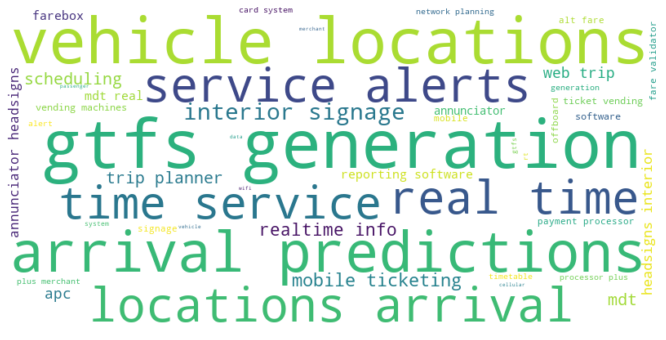

In [55]:
word_cloud_gen(elements_only)

### Most popular vendors by contract awarded

In [56]:
vendors2 = (
    contracts.contract_vendor.value_counts()
    .to_frame()
    .reset_index()
    .head(10)
    .rename(columns={"index": "vendor", "contract_vendor": "number_of_contracts"})
)

In [57]:
bar_chart(vendors2, "number_of_contracts", "vendor")

alt.Chart(...)

### Organizations that hold the most contracts

In [58]:
contract_holders = (
    contracts.contract_holder.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "holders", "contract_holder": "# contracts"})
    .head(10)
)

In [59]:
bar_chart(contract_holders, "# contracts", "holders")

alt.Chart(...)